<a href="https://colab.research.google.com/github/Koks-creator/OcrBenthamDataset/blob/main/bentham_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python==4.12.0.88

In [ ]:
!wget https://zenodo.org/records/44519/files/BenthamDatasetR0-Images.tbz

--2025-10-24 07:37:24--  https://zenodo.org/records/44519/files/BenthamDatasetR0-Images.tbz
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2019386713 (1.9G) [application/octet-stream]
Saving to: ‘BenthamDatasetR0-Images.tbz’

BenthamDatasetR0-Im 100%[===================>]   1.88G  31.1MB/s    in 39s     

2025-10-24 07:38:03 (49.5 MB/s) - ‘BenthamDatasetR0-Images.tbz’ saved [2019386713/2019386713]



In [ ]:
!rm -rf BenthamDatasetR0-Images-Copy1

In [ ]:
!tar -xvjf BenthamDatasetR0-Images.tbz

BenthamDatasetR0-Images/
BenthamDatasetR0-Images/Images/
BenthamDatasetR0-Images/Images/Pages/
BenthamDatasetR0-Images/Images/Pages/071_184_003.jpg
BenthamDatasetR0-Images/Images/Pages/071_169_001.jpg
BenthamDatasetR0-Images/Images/Pages/115_010_001.jpg
BenthamDatasetR0-Images/Images/Pages/096_100_003.jpg
BenthamDatasetR0-Images/Images/Pages/073_002_002.jpg
BenthamDatasetR0-Images/Images/Pages/071_101_004.jpg
BenthamDatasetR0-Images/Images/Pages/115_080_004.jpg
BenthamDatasetR0-Images/Images/Pages/115_080_002.jpg
BenthamDatasetR0-Images/Images/Pages/115_111_004.jpg
BenthamDatasetR0-Images/Images/Pages/116_131_001.jpg
BenthamDatasetR0-Images/Images/Pages/071_185_002.jpg
BenthamDatasetR0-Images/Images/Pages/071_185_003.jpg
BenthamDatasetR0-Images/Images/Pages/115_108_002.jpg
BenthamDatasetR0-Images/Images/Pages/071_201_001.jpg
BenthamDatasetR0-Images/Images/Pages/096_098_002.jpg
BenthamDatasetR0-Images/Images/Pages/115_111_003.jpg
BenthamDatasetR0-Images/Images/Pages/116_290_001.jpg
Bent

In [ ]:
# Pobranie plików to do ocr
#!wget https://zenodo.org/records/44519/files/BenthamDatasetR0-Images.tbz
!wget https://zenodo.org/records/44519/files/BenthamDatasetR0-GT.tbz 2>&1

# Rozpakowanie plików
#!tar -xvjf BenthamDatasetR0-Images.tbz
!tar -xvjf BenthamDatasetR0-GT.tbz

In [ ]:
# import tensorflow as tf
# from keras import backend as K

# # Wyczyść sesję Keras
# K.clear_session()

# # Wyczyść pamięć GPU TensorFlow
# tf.keras.backend.clear_session()

# # Garbage collection
# import gc
# gc.collect()

In [ ]:
import os
from glob import glob
import csv
# from google.colab import drive
from typing import Tuple, List
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from tensorflow.types.experimental import TensorLike
import cv2
# from google.colab.patches import cv2_imshow
from keras.saving import register_keras_serializable
import pickle
import pandas as pd
from collections import Counter
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# 1. Ustaw alokator
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# 3. Dynamiczny wzrost pamięci
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Opcjonalnie ogranicz pamięć
            # tf.config.set_logical_device_configuration(
            #     gpu,
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )
    except RuntimeError as e:
        print(e)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
DATASET_PATH = "BenthamDatasetR0-GT"
IMAGES_LINES_PATH = f"{DATASET_PATH}/Images/Lines"
TRANSCRIPTIONS_PATH = f"{DATASET_PATH}/Transcriptions"
TRAIN_SIZE = .8
VAL_SIZE = .15
TEST_SIZE = .05
AUTOTUNE = tf.data.AUTOTUNE
CHECKPOINT_PATH = "/content/drive/MyDrive/ocr_checkpoints/checkpoint_{epoch:02d}"
LOAD_CHECKPOINT = False
MODEL_PATH = "ocr_model.h5"
NUM2CHAR_PATH = "num_to_char.pkl"
CHECKPOINT_PERIODS = 10
WARMUP = False # can't use it with ReduceLROnPlateau
AUGMENT = False

# HYPER PARAMS
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
PADDING_TOKEN = 99
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 128
RNN_LAYERS = 3
RNN_UNITS = 768
OOV_TOKEN = "[UNK]"
EPOCHS = 70

In [ ]:
images_list = glob(f"{IMAGES_LINES_PATH}/*.png")
images_list.sort()

transcriptions_list = glob(f"{TRANSCRIPTIONS_PATH}/*.txt")
transcriptions_list.sort()

In [ ]:
# 2. Sprawdź że masz tyle samo
assert len(images_list) == len(transcriptions_list), "Różne liczby plików!"

# 3. Stwórz indeksy i zashuffle je
indices = list(range(len(images_list)))
random.seed(SEED)
random.shuffle(indices)

# 4. Użyj tych samych indeksów dla obu list
images_list = [images_list[i] for i in indices]
transcriptions_list = [transcriptions_list[i] for i in indices]

In [ ]:
counter = Counter()

for img_path in images_list[:100]:
    img = cv2.imread(img_path)
    counter[img.shape] += 1

In [ ]:
assert len(images_list) == len(transcriptions_list)

In [ ]:
num_samples = len(transcriptions_list)
train_range = slice(0, int(TRAIN_SIZE * num_samples))
val_range = slice(int(train_range.stop), int(train_range.stop + (VAL_SIZE * num_samples)))
test_range = slice(val_range.stop,  int(val_range.stop + (TEST_SIZE * num_samples)))

In [ ]:
def get_transcriptions(transcriptions_path: List):
    labels = []
    for transcription_path in transcriptions_path:
        with open(transcription_path) as f:
            file_content = f.read()
            labels.append(file_content.replace("\n", "").replace("  <gap/>", "").replace("<gap/>", ""))

    return labels

In [ ]:
train_image_paths, train_transcriptions = images_list[train_range], transcriptions_list[train_range]
train_transcriptions = get_transcriptions(train_transcriptions)

val_image_paths, val_transcriptions = images_list[val_range], transcriptions_list[val_range]
val_transcriptions = get_transcriptions(val_transcriptions)

test_image_paths, test_transcriptions = images_list[test_range], transcriptions_list[test_range]
test_transcriptions = get_transcriptions(test_transcriptions)

In [ ]:
assert len(train_image_paths) == len(train_transcriptions)
assert len(val_image_paths) == len(val_transcriptions)
assert len(test_image_paths) == len(test_transcriptions)

In [ ]:
# Creating vocabulary
sentences_data = []
sentence_lengths = []
sents_length = {
    "0-30": 0,
    "30-50": 0,
    "50-60": 0,
    "60-70": 0,
    "70-110": 0
}
train_labels_cleaned = []
chars = set()
max_len = 0

for label in train_transcriptions:
    for char in label:
        chars.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)
    # input(len(label))
    for key in sents_length:
      left_if, right_if = [int(k) for k in key.split("-")]

      if left_if < len(label) < right_if:
          # input((left_if, right_if))
          sents_length[key] += 1
    sentence_lengths.append(len(label))


print(f"Max len: {max_len}")
print(f"Vocab size: {len(chars)}")
print(f"{len(sentences_data)=}")
print(f"{min(sentence_lengths)=}")
print(f"{max(sentence_lengths)=}")
print(f"{np.mean(sentence_lengths)=}")
print(f"{np.median(sentence_lengths)=}")
print(f"{sents_length=}")

Max len: 107
Vocab size: 89
len(sentences_data)=0
min(sentence_lengths)=1
max(sentence_lengths)=107
np.mean(sentence_lengths)=np.float64(46.90270211375027)
np.median(sentence_lengths)=np.float64(53.0)
sents_length={'0-30': 1781, '30-50': 1743, '50-60': 2640, '60-70': 1949, '70-110': 384}


In [ ]:
chars

{' ',
 '!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|',
 '£',
 '§',
 'à',
 'è',
 'ê',
 '⊥'}

In [ ]:
max_len = 110 # for valid ds it was 107, shiieeeet

In [ ]:
char_to_num = StringLookup(vocabulary=list(chars), mask_token=None, oov_token=OOV_TOKEN)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, oov_token=OOV_TOKEN, invert=True)

In [ ]:
print(char_to_num.get_vocabulary())

['[UNK]', np.str_('+'), np.str_('P'), np.str_('g'), np.str_('i'), np.str_('1'), np.str_('9'), np.str_('Y'), np.str_('u'), np.str_('T'), np.str_(':'), np.str_('7'), np.str_('f'), np.str_('I'), np.str_('r'), np.str_('ê'), np.str_('v'), np.str_('l'), np.str_('?'), np.str_('3'), np.str_('x'), np.str_('"'), np.str_('2'), np.str_('D'), np.str_('Q'), np.str_('&'), np.str_(' '), np.str_('t'), np.str_('X'), np.str_('K'), np.str_('0'), np.str_('W'), np.str_('m'), np.str_('!'), np.str_('o'), np.str_('H'), np.str_('V'), np.str_('4'), np.str_('S'), np.str_("'"), np.str_('n'), np.str_('c'), np.str_(')'), np.str_('y'), np.str_('w'), np.str_(';'), np.str_('8'), np.str_('A'), np.str_('p'), np.str_('M'), np.str_('6'), np.str_('5'), np.str_('F'), np.str_('='), np.str_('U'), np.str_('d'), np.str_('£'), np.str_('G'), np.str_('C'), np.str_('h'), np.str_('L'), np.str_('N'), np.str_('⊥'), np.str_('|'), np.str_(']'), np.str_('-'), np.str_('['), np.str_('_'), np.str_('e'), np.str_('z'), np.str_('B'), np.str_(',

In [ ]:
# def augment_image(image):
#     # Random rotation
#     image = keras.layers.RandomRotation(0.02)(image)
#     # Random brightness
#     image = keras.layers.RandomBrightness(0.2)(image)
#     # Random contrast
#     image = keras.layers.RandomContrast(0.2)(image)
#     return image

In [ ]:
def preprocess_image(image_path: str, img_size: Tuple[int, int] = (IMAGE_HEIGHT, IMAGE_WIDTH)) -> TensorLike:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 # normalize data

    return image

def vectorize_label(label: str, padding_token: int = PADDING_TOKEN, max_len: int = max_len) -> TensorLike:
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]

    pad_amount = max_len - length if max_len - length > 0 else 0

    # if max_len - length <
    # pad_amount = tf.maximum(0, max_len - length) # nigga, padding cannot be negative :P
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)

    return label

def distortion_free_resize(image: TensorLike, img_size: Tuple[int, int]) -> TensorLike:
    w = img_size[1]
    h = img_size[0]
    # Resize with aspect ratio preserved.
    image = tf.image.resize(
        image, size=(h, w), preserve_aspect_ratio=True
    )

    # Calculate how much padding (height & width) is needed
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Split that padding equally on top/bottom and left/right
    # (If the needed pad is odd, we add the "extra" pixel on top/left)
    if pad_height % 2 != 0:
        half = pad_height // 2
        pad_height_top = half + 1
        pad_height_bottom = half
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        half = pad_width // 2
        pad_width_left = half + 1
        pad_width_right = half
    else:
        pad_width_left = pad_width_right = pad_width // 2

    # Apply symmetric padding
    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ]
    )

    # image = tf.transpose(image, perm=[1, 0, 2])
    # image = tf.image.flip_left_right(image)

    return image

# def augment_image(image):
#     # losowa jasność
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     # losowy kontrast
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     # drobna losowa rotacja np. -5 do 5 stopni
#     # Uwaga: tf.image.rot90 obraca o 90 stopni – nie o to chodzi
#     # można użyć tf.keras.preprocessing.image.random_rotation,
#     # ale w tf 2.x jest to trudniejsze do wpięcia w pipeline
#     # Inny sposób – transformacje macierzowe z tf.keras.layers.experimental.preprocessing
#     return image

def augment_image(image):
    """
    TYLKO brightness/contrast - bez rotation/shear!
    """
    # Delikatne zmiany jasności
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)  # Bardzo mało!

    # Delikatne zmiany kontrastu
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Bardzo mało!

    return tf.clip_by_value(image, 0.0, 1.0)

def process_images_labels(image_path: str, label: str, train: bool = False) -> Tuple[TensorLike, TensorLike]:
    image = preprocess_image(image_path)
    if train:
        image = augment_image(image)
    label = vectorize_label(label)

    return image, label

def prepare_dataset(image_paths: list, labels: list, batch_size: int = BATCH_SIZE, train: bool = False) -> tf.data.Dataset:
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        # process_images_labels,
        lambda img_path, label: process_images_labels(img_path, label, train=train),
        num_parallel_calls=AUTOTUNE
    )


    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
train_ds = prepare_dataset(image_paths=train_image_paths, labels=train_transcriptions, train=AUGMENT)
val_ds = prepare_dataset(image_paths=val_image_paths, labels=val_transcriptions)
test_ds = prepare_dataset(image_paths=test_image_paths, labels=test_transcriptions)

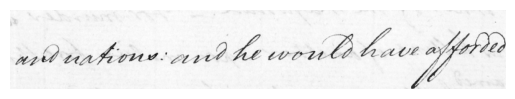

In [ ]:
# Regular resize
for img_path in train_image_paths[:1]:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, 1)
    img = tf.image.resize(img, size=(IMAGE_HEIGHT, IMAGE_WIDTH))

    img_np = img.numpy().astype(np.uint8)

    if img_np.shape[-1] == 1:
        img_np = img_np.squeeze()

    plt.imshow(img_np, cmap="gray")
    plt.axis("off")
    plt.show()
    break

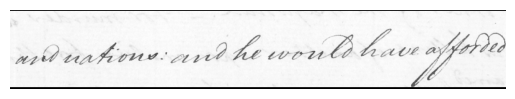

In [ ]:
# Distortion free resize
for img_path in train_image_paths[:1]:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, 1)
    img = distortion_free_resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))

    img_np = img.numpy().astype(np.uint8)

    if img_np.shape[-1] == 1:
        img_np = img_np.squeeze()

    plt.imshow(img_np, cmap="gray")
    plt.axis("off")
    plt.show()
    break

2025-10-22 17:37:11.357275: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


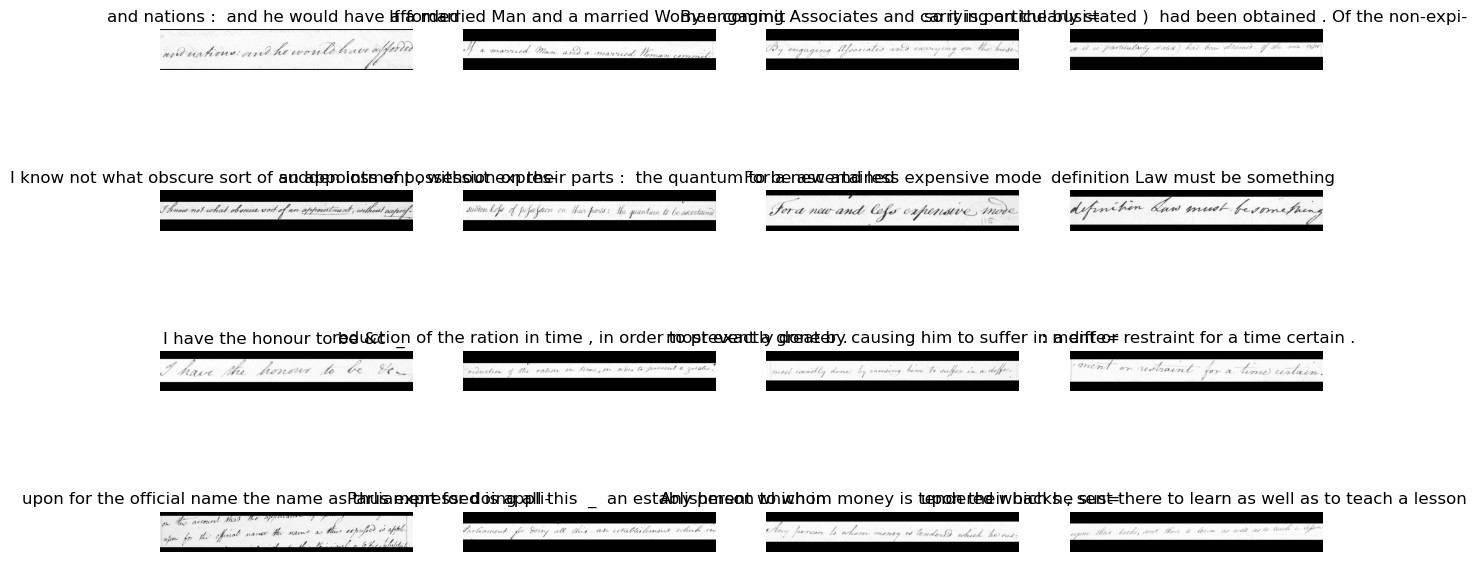

In [ ]:
for data in train_ds.take(1):
    # images, labels = data["image"], data["label"]
    images, labels = data

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(BATCH_SIZE):
        img = images[i]
        # img = tf.image.flip_left_right(img)
        # img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label != padding_token
        label = labels[i]

        indices = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))

        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
@register_keras_serializable(package="Custom")
def CTCLoss(y_true: TensorLike, y_pred: TensorLike, padding_token: int = PADDING_TOKEN) -> tf.Tensor:
    """
    y_true: (batch, max_len) with character indices and 99 as PAD (padding).
    y_pred: (batch, time_steps, vocab_size) - network output (logits or probabilities).
    """
    # Get batch size and number of time steps from shapes
    batch_size = tf.shape(y_true)[0]
    time_steps = tf.shape(y_pred)[1]

    # Calculate how many characters are not the padding token (actual sequence length per sample) - in other words count label len with no padding values
    label_length = tf.reduce_sum(
        tf.cast(tf.not_equal(y_true, padding_token), tf.int32),
        axis=1,       # sum along the character (sequence) axis
        keepdims=True # the result will then have shape (batch, 1)
    )

    # For the predictions y_pred, we assume each sample has input_length = time_steps
    input_length = time_steps * tf.ones((batch_size, 1), dtype=tf.int32)

    # ctc_batch_cost expects (y_true, y_pred, input_length, label_length)
    loss = keras.backend.ctc_batch_cost(
        y_true,       # true labels
        y_pred,       # predictions
        input_length, # number of time steps per sample
        label_length  # actual length of each label (no pads)
    )
    return loss


@register_keras_serializable(package="Custom")
def ctc_accuracy(y_true: TensorLike, y_pred: TensorLike, padding_token: int = PADDING_TOKEN) -> tf.Tensor:
    """
    y_true: (batch, max_len) with PAD=99
    y_pred: (batch, time_steps, vocab_size)
    """
    batch_size = tf.shape(y_pred)[0]
    time_steps = tf.shape(y_pred)[1]

    # The decoder requires the length of each input sequence
    # Here, we assume it's simply time_steps for all samples
    input_lengths = tf.fill([batch_size], time_steps)

    # Remove the padding from y_true and create a SparseTensor of actual labels
    y_true = tf.cast(y_true, tf.int64)
    indices = tf.where(tf.not_equal(y_true, padding_token))  # positions where value != 99
    values = tf.gather_nd(y_true, indices)                   # extract those values
    dense_shape = tf.cast(tf.shape(y_true), tf.int64)
    y_true_sparse = tf.SparseTensor(indices, values, dense_shape)

    # Greedy decoding of y_pred:
    # We transpose y_pred to shape (time_steps, batch, vocab_size),
    # because tf.nn.ctc_greedy_decoder expects it in this format.
    decoded, _ = tf.nn.ctc_greedy_decoder(
        tf.transpose(y_pred, [1, 0, 2]),
        input_lengths,
        merge_repeated=True
    )
    # Cast the decoded result to int64
    decoded_sparse = tf.cast(decoded[0], tf.int64)

    # Calculate accuracy via edit distance:
    # accuracy = 1 - average_edit_distance
    accuracy = 1 - tf.reduce_mean(
        tf.edit_distance(decoded_sparse, y_true_sparse, normalize=True)
    )
    return accuracy

In [ ]:
class WarmupSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=0.0001, warmup_epochs=5, steps_per_epoch=574):
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_epochs * steps_per_epoch

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        # Linear warmup od 0 do initial_lr
        warmup_lr = (self.initial_lr / warmup_steps) * step

        return tf.where(step < warmup_steps, warmup_lr, self.initial_lr)

In [ ]:
def build_model(
    char_to_num: keras.layers.StringLookup,
    img_width: int = IMAGE_WIDTH,
    img_height: int = IMAGE_HEIGHT,
    rnn_layers: int = RNN_LAYERS,
    rnn_units: int = RNN_UNITS,
    learning_rate: float = LEARNING_RATE,
    warmup: bool = WARMUP
) -> keras.Model:

    img_input = keras.Input(shape=(img_height, img_width, 1), name="image")

    # CNN 1
    x = keras.layers.Conv2D(32, (3, 3), padding="same", use_bias=False)(img_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)

    # CNN 2
    x = keras.layers.Conv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)

    # CNN 3
    x = keras.layers.Conv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)

    # CNN 4 (no pooling)
    x = keras.layers.Conv2D(128, (3, 3), padding="same", use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # Axis swap (height and width) => (batch, H//8, W//8, 128)
    x = keras.layers.Permute((2, 1, 3), name="permute")(x)

    # Reshape: (batch, W//4, (H//4)*128)
    x = keras.layers.Reshape(
        (img_width // 4, (img_height // 4) * 128),  # the number of fitlers in the last cnn
        name="reshape"
    )(x)

    for i in range(rnn_layers):
        x = keras.layers.Bidirectional( #lstm do dupy
            keras.layers.GRU(rnn_units, return_sequences=True, dropout=0.4)
        )(x)
        if i < rnn_layers - 1:  # Nie po ostatniej warstwie
            x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Dense(rnn_units * 2, activation="relu", name="dense_1")(x)
    x = keras.layers.Dropout(0.3)(x)

    vocab_size = len(char_to_num.get_vocabulary())
    output = keras.layers.Dense(
        vocab_size + 1,
        activation="softmax",
        name="dense_2"
    )(x)

    model = keras.Model(inputs=img_input, outputs=output)
    if warmup:
        learning_rate_comp = WarmupSchedule(initial_lr=learning_rate, warmup_epochs=5)
    else:
        learning_rate_comp = learning_rate

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate_comp, clipnorm=5.0),
        loss=CTCLoss,
        metrics=[ctc_accuracy]
    )
    return model

In [ ]:
pythonvalidation_images = []
validation_labels = []
validation_images = []
# Dodaj licznik by śledzić, która iteracja powoduje błąd
batch_count = 0
try:
    for batch in val_ds:
        try:
            batch_count += 1
            print(f"Processing batch {batch_count}")
            images, labels = batch

            # Sprawdź kształty w każdej partii
            print(f"Batch shapes: images={images.shape}, labels={labels.shape}")

            for i in range(images.shape[0]):
                validation_images.append(images[i])
                validation_labels.append(labels[i])

        except Exception as e:
            print(f"Error in batch {batch_count}: {e}")
            # Można kontynuować mimo błędu
            continue
except Exception as e:
    print(f"Failed at batch {batch_count}: {e}")

Processing batch 1
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 2
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 3
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 4
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 5
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 6
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 7
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 8
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 9
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 10
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 11
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 12
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processing batch 13
Batch shapes: images=(16, 128, 800, 1), labels=(16, 110)
Processi

In [ ]:
# validation_images = []
# validation_labels = []

# for batch in val_ds:
#     images, labels = batch

#     for i in range(images.shape[0]):
#         validation_images.append(images[i])   # (32, 128, 1)
#         validation_labels.append(labels[i])

In [ ]:
validation_images[0].shape

TensorShape([128, 800, 1])

In [ ]:
def remove_padding_with_ragged(labels, pad_token: int = PADDING_TOKEN, no_sparse: bool = False):
    """
    Usuwa wszystkie wystąpienia `pad_token` z sekwencji za pomocą RaggedTensors.
    labels ma kształt (batch, max_len).
    Zwraca sparse tensor bez 99.
    """
    # Tworzymy RaggedTensor, który ignoruje pad_token:
    ragged = tf.ragged.boolean_mask(labels, labels != pad_token)
    # Konwertujemy RaggedTensor -> SparseTensor
    if no_sparse:
        return ragged
    return ragged.to_sparse()


def calculate_edit_distance(labels, predictions, max_len=None, pad_token=PADDING_TOKEN):
    """
    Zwraca średnią odległość edycyjną (edit distance) w batchu.
    labels: (batch, max_len) z wypełnieniem 99.
    predictions: (batch, time_steps, vocab_size) – wyniki modelu.
    """

    # 1) Zamiana etykiet na tensor rzadki, bez 99
    sparse_labels = remove_padding_with_ragged(labels, pad_token=pad_token)
    sparse_labels = tf.cast(sparse_labels, dtype=tf.int64)

    # 2) Dekodowanie predykcji przez CTC
    batch_size = predictions.shape[0]
    time_steps = predictions.shape[1]
    # ctc_decode oczekuje, że input_length będzie Tensorem
    input_len = tf.ones([batch_size], dtype=tf.int32) * time_steps

    decoded, _ = keras.backend.ctc_decode(
        predictions,
        input_length=input_len,
        greedy=True,
    )
    # decoded to lista wyników (tu jest tylko 1 element przy greedy=True)
    # kształt: (batch, max_decoded_length)
    predictions_decoded = decoded[0]

    # Jeśli chcesz skrócić do `max_len` (np. unikając zbyt długich wyjść):
    if max_len is not None:
        predictions_decoded = predictions_decoded[:, :max_len]

    # 3) Zamiana zdekodowanych predykcji na tensor rzadki
    #    (tu zwykle nie ma 99, więc wystarczy from_dense)
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # 4) Obliczenie odległości edycyjnej (tu na przykład normalizowanej)
    edit_distances = tf.edit_distance(
        sparse_predictions,
        sparse_labels,
        normalize=True
    )

    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    """
    Callback obliczający średnią odległość edycyjną (mean edit distance)
    po każdej epoce na zbiorze walidacyjnym.
    """

    def __init__(self, pred_model, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.validation_images = validation_images
        self.validation_labels = validation_labels

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.validation_images)):
            # Obraz: zakładamy, że self.validation_images[i] to (128, 32, 1).
            # Dodanie wymiaru batch -> (1, 128, 32, 1).
            single_image = self.validation_images[i][None, ...]

            # Etykiety: jeśli self.validation_labels[i] ma kształt (seq_len,),
            # to dodanie wymiaru batch -> (1, seq_len).
            single_label = self.validation_labels[i][None, ...]

            # Predykcja
            predictions = self.prediction_model.predict(single_image, verbose=0)

            # Obliczanie edytowalności
            ed = calculate_edit_distance(single_label, predictions).numpy()
            edit_distances.append(ed)

        mean_ed = np.mean(edit_distances)
        print(f" Mean edit distance for epoch {epoch + 1}: {mean_ed:.4f}")


In [ ]:
model = build_model(char_to_num, warmup=WARMUP)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 800, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 800, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 800, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 800, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 400, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 400, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 400, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 400, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 200, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 200, 64)    │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 200, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32, 200, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 200, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 200, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32, 200, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 200, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 200, 4096)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 200, 1536)      │    22,422,528 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200, 1536)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 200, 1536)      │    10,626,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200, 1536)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 200, 1536)      │    10,626,04

 Total params: 46,305,787 (176.64 MB)

 Trainable params: 46,305,211 (176.64 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
# Create a submodel that shares the same weights as the original model, outputting from layer "dense_2"
prediction_model = keras.models.Model(
    model.input,
    model.get_layer(name="dense_2").output
)

In [ ]:
assert prediction_model.input == model.input

In [ ]:
class CustomCSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_path):
        super().__init__()
        self.log_path = log_path
        self.epoch = 0

    def on_train_begin(self, logs = None) -> None:
        if os.path.exists(self.log_path):
            self.mode = "a"
            self.header = False
        else:
            self.mode = "w"
            self.header = True

        self.csvfile = open(self.log_path, self.mode, newline='')
        self.writer = csv.writer(self.csvfile)

        if self.header:
            self.writer.writerow(["epoch", "loss", "val_loss", "ctc_accuracy", "val_ctc_accuracy"])
            self.csvfile.flush()
        self.csvfile.close()

    def on_epoch_end(self, epoch: int, logs = None) -> None:
        logs = logs or {}
        with open(self.log_path, "a", newline='') as csvfile:
            writer = csv.writer(csvfile)
            row = [
                epoch,  # numer epoki
                logs.get("loss", "N/A"),
                logs.get("val_loss", "N/A"),
                logs.get("ctc_accuracy", "N/A"),
                logs.get("val_ctc_accuracy", "N/A"),
            ]
            writer.writerow(row)

In [ ]:
class PeriodicCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, base_checkpoint_callback, period=10):
        super().__init__()
        self.base_checkpoint_callback = base_checkpoint_callback
        self.period = period

    def on_train_begin(self, logs=None):
        self.base_checkpoint_callback.set_model(self.model)
        self.base_checkpoint_callback.set_params(self.params)

        self.base_checkpoint_callback.on_train_begin(logs)

    def on_train_batch_end(self, batch, logs=None):
        self.base_checkpoint_callback.on_train_batch_end(batch, logs)

    def on_epoch_begin(self, epoch, logs=None):
        self.base_checkpoint_callback.on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            self.base_checkpoint_callback.on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        self.base_checkpoint_callback.on_train_end(logs)

In [ ]:
callbacks = [
     # checkpoint_every_period,
     CustomCSVLogger(fr"training_log.csv"),
     EditDistanceCallback(prediction_model, validation_images[:200], validation_labels[:200]),
     keras.callbacks.EarlyStopping(
        monitor='val_ctc_accuracy',
        patience=10,              # Czeka 15 epok bez poprawy
        restore_best_weights=True, # Przywraca najlepsze wagi!
        mode='max',
        verbose=1
     ),

    # 2. ReduceLROnPlateau - zmniejsza LR gdy utkniesz
     keras.callbacks.ReduceLROnPlateau(
        monitor='val_ctc_accuracy',
        factor=0.5,               # Zmniejsza LR o 50%
        patience=5,               # Po 7 epokach bez poprawy
        min_lr=1e-6,
        mode='max',
        verbose=1
     ),
    #  lr_schedule
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[callbacks],
    initial_epoch=0 # last epoch number-1
)

Epoch 1/70
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - ctc_accuracy: -0.1362 - loss: 164.7968 Mean edit distance for epoch 1: 11.9751
574/574 ━━━━━━━━━━━━━━━━━━━━ 88s 143ms/step - ctc_accuracy: 0.0580 - loss: 135.8980 - val_ctc_accuracy: 0.1427 - val_loss: 152.9788 - learning_rate: 1.0000e-04
Epoch 2/70
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - ctc_accuracy: 0.2891 - loss: 93.2817 Mean edit distance for epoch 2: 11.7186
574/574 ━━━━━━━━━━━━━━━━━━━━ 77s 135ms/step - ctc_accuracy: 0.3419 - loss: 86.0439 - val_ctc_accuracy: 0.4462 - val_loss: 68.8742 - learning_rate: 1.0000e-04
Epoch 3/70
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - ctc_accuracy: 0.4907 - loss: 64.3732 Mean edit distance for epoch 3: 11.4381
574/574 ━━━━━━━━━━━━━━━━━━━━ 77s 135ms/step - ctc_accuracy: 0.5391 - loss: 57.5171 - val_ctc_accuracy: 0.6256 - val_loss: 43.0844 - learning_rate: 1.0000e-04
Epoch 4/70
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - ctc_accuracy: 0.6409 - loss: 42.1734 Mean edit distance for epoch 4

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


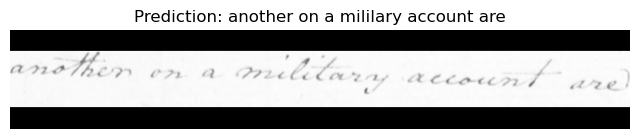

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


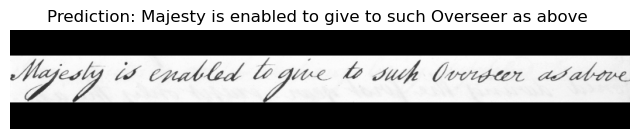

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


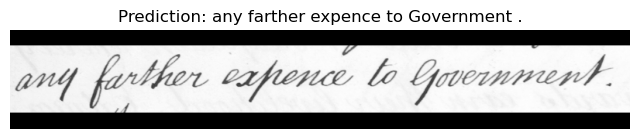

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


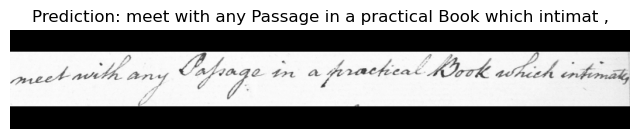

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


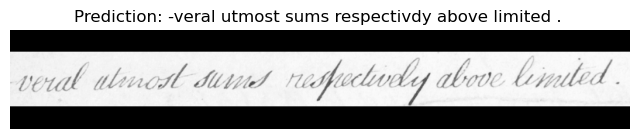

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2025-10-22 18:35:37.649234: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


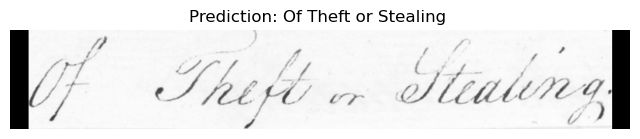

In [ ]:
for batch_images, batch_labels in test_ds.take(6):
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    img = batch_images[5]
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"Prediction: {pred_texts[5]}"

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2025-10-22 18:35:37.873107: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


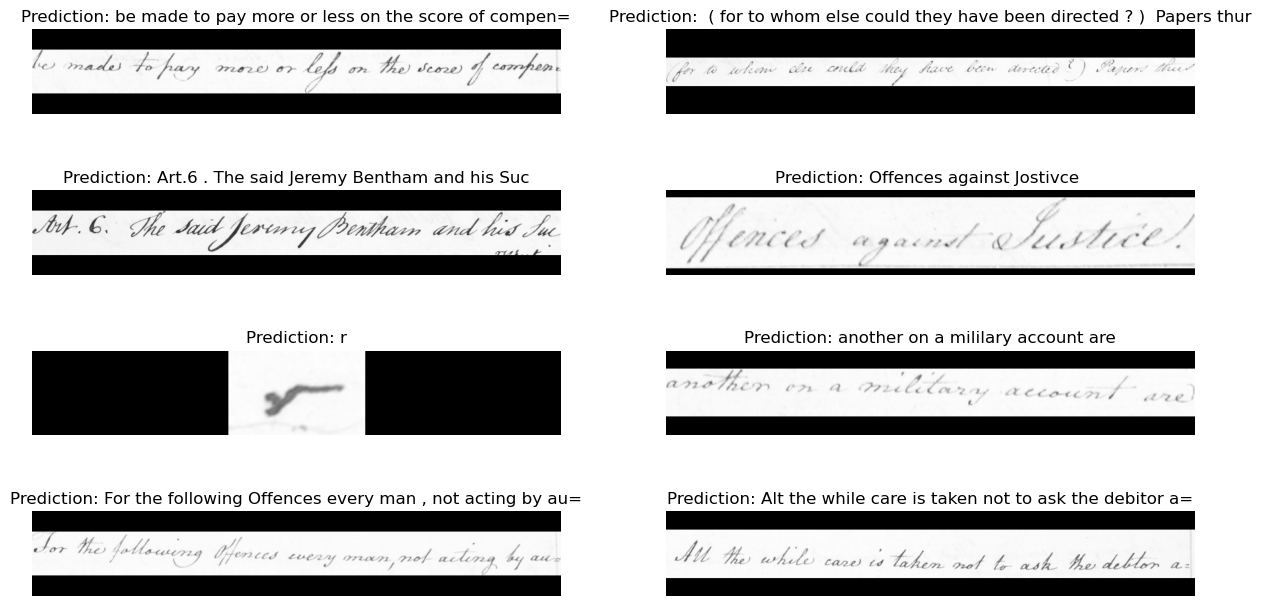

In [ ]:
# Let's check results on some test samples.
for  batch_images, bath_labels in test_ds.take(1):
    _, ax = plt.subplots(4,2, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(8):
        img = batch_images[i]
        # img = tf.image.flip_left_right(img)
        # img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(title)
        ax[i // 2, i % 2].axis("off")

    plt.show()

In [ ]:
prediction_model.save(MODEL_PATH)

with open(NUM2CHAR_PATH, "wb") as c2n_file:
    pickle.dump(num_to_char, c2n_file)

In [ ]:
train_hist_df = pd.read_csv("training_log.csv")

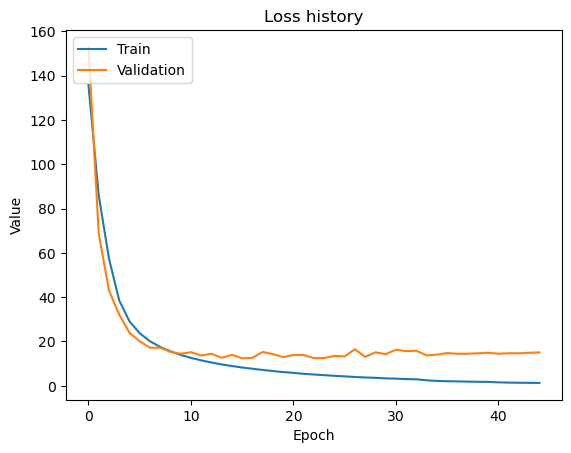

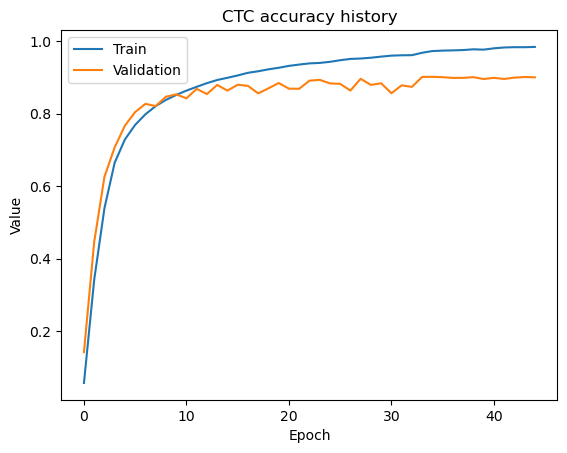

In [ ]:
plt.plot(train_hist_df["loss"])
plt.plot(train_hist_df["val_loss"])
plt.title("Loss history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_hist_df["ctc_accuracy"])
plt.plot(train_hist_df["val_ctc_accuracy"])
plt.title("CTC accuracy history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()